In [1]:
import json
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import importlib
import sys
sys.path.insert(0, '../utils')
import data_utils
import visualization
import evaluation

# importlib.reload(visualization)

sys.path.insert(0, '../models')
import log_reg_word_embeddings

In [3]:
df_train = data_utils.load_data_set('../data/train/train.csv')
df_train_x = df_train[['head.word', 'tail.word', 'sentence']]
df_train_y = df_train['relation']

In [15]:
df_test = data_utils.load_data_set('../data/test/test.csv')
df_test_x = df_test[['head.word', 'tail.word', 'sentence']]
df_test_y = df_test['relation']

In [35]:
with open('../data/classes.json') as f:
    classes_json = json.load(f)
classes = np.asarray(list(classes_json.keys()))

In [17]:
from nltk.tokenize import RegexpTokenizer
space_tokenizer = RegexpTokenizer(r'\w+')
tokenized = df_train_x['sentence'].append(df_test_x['sentence']).apply(space_tokenizer.tokenize)
tokenized_lengths = tokenized.apply(len)

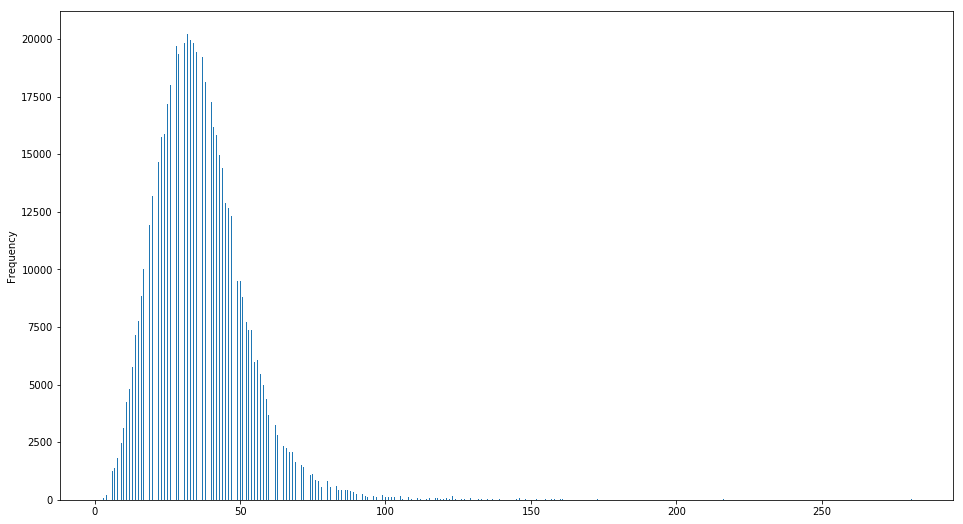

In [18]:
plt.rcParams['figure.figsize'] = (16, 9)
tokenized_lengths.plot.hist(bins=1000)

In [16]:
from collections import Counter

vocabulary = Counter()
df_train_x['sentence'].str.lower().str.split().apply(vocabulary.update)
df_test_x['sentence'].str.lower().str.split().apply(vocabulary.update)

0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
15        None
16        None
17        None
18        None
19        None
20        None
21        None
22        None
23        None
24        None
25        None
26        None
27        None
28        None
29        None
          ... 
522581    None
522582    None
522583    None
522584    None
522585    None
522586    None
522587    None
522588    None
522589    None
522590    None
522591    None
522592    None
522593    None
522594    None
522595    None
522596    None
522597    None
522598    None
522599    None
522600    None
522601    None
522602    None
522603    None
522604    None
522605    None
522606    None
522607    None
522608    None
522609    None
522610    None
Name: sentence, Length: 521752, dtype: object

0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
15        None
16        None
17        None
18        None
19        None
20        None
21        None
22        None
23        None
24        None
25        None
26        None
27        None
28        None
29        None
          ... 
172418    None
172419    None
172420    None
172421    None
172422    None
172423    None
172424    None
172425    None
172426    None
172427    None
172428    None
172429    None
172430    None
172431    None
172432    None
172433    None
172434    None
172435    None
172436    None
172437    None
172438    None
172439    None
172440    None
172441    None
172442    None
172443    None
172444    None
172445    None
172446    None
172447    None
Name: sentence, Length: 172442, dtype: object

In [19]:
len(vocabulary)

185328

In [27]:
MAX_WORDS = 150000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df_train_x['sentence'].append(df_test_x['sentence']))
# tokenizer.word_index

In [30]:
word_index = tokenizer.word_index

In [26]:
# load GloVe 100 dim word embeddings
embeddings_index = {}
f = open('../data/external/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [31]:
# use word_index and embeddings_index to construct embedding_matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [32]:
embedding_matrix.shape

(147420, 100)

In [65]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential()

# model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu', padding='same')) # TODO: why padding?
model.add(MaxPooling1D(35, padding='same')) # TODO: why padding?

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          14742000  
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 96, 128)           64128     
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 19, 128)           0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 15, 128)           82048     
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 3, 128)            0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 3, 128)            82048     
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 1, 128)            0         
__________

In [5]:
model = log_reg_word_embeddings.LogRegWordEmbeddings()

In [6]:
model.fit(df_train_x, df_train_y)

Tokenizing sentences...
0    [she, also, oversaw, refinancing, state, super...
1    [more, 2, 5, million, cubic, yards, contaminat...
2    [the, onondaga, nation, 1, 500, members, feder...
3    [he, born, istanbul, raised, eastern, city, ad...
4    [by, end, recent, tour, rollins, met, soldiers...
Name: sentence, dtype: object
Averaging word embeddings...
0    [-0.024940285714285717, -0.014328357142857137,...
1    [0.022366650000000002, 0.060093550000000016, -...
2    [-0.02160072727272727, 0.10642886363636364, -0...
3    [0.012861874999999998, 0.0178651875, -0.102017...
4    [0.07083508108108107, 0.03429608108108108, -0....
Name: sentence, dtype: object
Shape of transformed input: (522517, 50)
Fitting label encoder...
['/broadcast/content/location' '/broadcast/producer/location'
 '/business/business_location/parent_company' '/business/company/advisors'
 '/business/company/founders' '/business/company/industry'
 '/business/company/locations' '/business/company/major_shareholders'
 '/bu

In [7]:
model.predict(df_train_x.head())

Tokenizing sentences...
0    [she, also, oversaw, refinancing, state, super...
1    [more, 2, 5, million, cubic, yards, contaminat...
2    [the, onondaga, nation, 1, 500, members, feder...
3    [he, born, istanbul, raised, eastern, city, ad...
4    [by, end, recent, tour, rollins, met, soldiers...
Name: sentence, dtype: object
Averaging word embeddings...
0    [-0.024940285714285717, -0.014328357142857137,...
1    [0.022366650000000002, 0.060093550000000016, -...
2    [-0.02160072727272727, 0.10642886363636364, -0...
3    [0.012861874999999998, 0.0178651875, -0.102017...
4    [0.07083508108108107, 0.03429608108108108, -0....
Name: sentence, dtype: object
Shape of transformed input: (5, 50)


array(['/location/us_county/county_seat',
       '/sports/sports_team_location/teams',
       '/location/location/contains', '/location/it_region/capital',
       '/location/country/capital'], dtype=object)

In [8]:
import pickle

save_dir = '../trained_models/log_reg_word_embeddings.pkl'
with open(save_dir, 'wb') as save_file:
    pickle.dump(model.model, save_file)

In [9]:
import pickle

save_dir = '../trained_models/log_reg_word_embeddings.pkl'

with open(save_dir, 'rb') as saved_file:
    loaded_model = pickle.load(saved_file)

In [10]:
loaded_model

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=6, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [12]:
predictions = model.predict(df_test_x)

Tokenizing sentences...
0    [the, little, comedy, mannered, operetta, base...
1    [a, court, rome, acquitted, five, people, accu...
2    [there, also, performers, born, louisiana, inc...
3    [when, julian, resuello, mayor, san, carlos, c...
4    [a3, concern, raised, libya, deal, alex, salmo...
Name: sentence, dtype: object
Averaging word embeddings...
0    [-0.04764994117647058, 0.043827, -0.0100119411...
1    [0.046854531250000005, -0.0070380000000000035,...
2    [0.02044745454545455, 0.013675363636363645, -0...
3    [0.10651433333333332, -0.028786888888888893, 0...
4    [0.0343515, -0.01823760714285715, 0.0274138928...
Name: sentence, dtype: object
Shape of transformed input: (172446, 50)


In [13]:
from collections import Counter
Counter(predictions)

predicted_labels = predictions
gold_labels = df_test_y

Counter(gold_labels)

Counter({'/broadcast/producer/location': 2376,
         '/location/it_region/capital': 1660,
         '/people/person/children': 23695,
         '/people/person/place_of_birth': 3583,
         '/people/ethnicity/geographic_distribution': 6357,
         '/people/person/nationality': 7176,
         '/people/person/ethnicity': 2856,
         '/people/ethnicity/people': 2876,
         '/business/company/major_shareholders': 1396,
         '/location/administrative_division/country': 9237,
         '/business/person/company': 4707,
         'NA': 13887,
         '/location/us_county/county_seat': 3759,
         '/people/person/profession': 2192,
         '/people/person/place_lived': 10463,
         '/location/us_state/capital': 9262,
         '/people/person/religion': 2725,
         '/business/company/founders': 5007,
         '/people/deceased_person/place_of_burial': 3607,
         '/people/deceased_person/place_of_death': 3179,
         '/location/country/capital': 8024,
         '/bus

Counter({'/people/person/place_of_birth': 162,
         '/people/person/nationality': 723,
         '/people/person/place_lived': 450,
         '/location/location/contains': 2793,
         '/sports/sports_team/location': 10,
         '/business/person/company': 302,
         '/location/country/capital': 553,
         '/business/company/founders': 95,
         '/film/film/featured_film_locations': 2,
         '/location/administrative_division/country': 424,
         '/location/us_county/county_seat': 23,
         '/people/deceased_person/place_of_death': 68,
         '/business/company/place_founded': 20,
         '/location/country/languages_spoken': 3,
         '/location/neighborhood/neighborhood_of': 68,
         '/people/person/children': 30,
         '/film/film_location/featured_in_films': 2,
         '/people/ethnicity/geographic_distribution': 136,
         '/location/country/administrative_divisions': 424,
         '/location/us_state/capital': 39,
         '/business/compan

In [65]:
combined_labels = np.append(df_test_y, [df_train_y]).reshape(-1, 1) # TODO: load the from a file

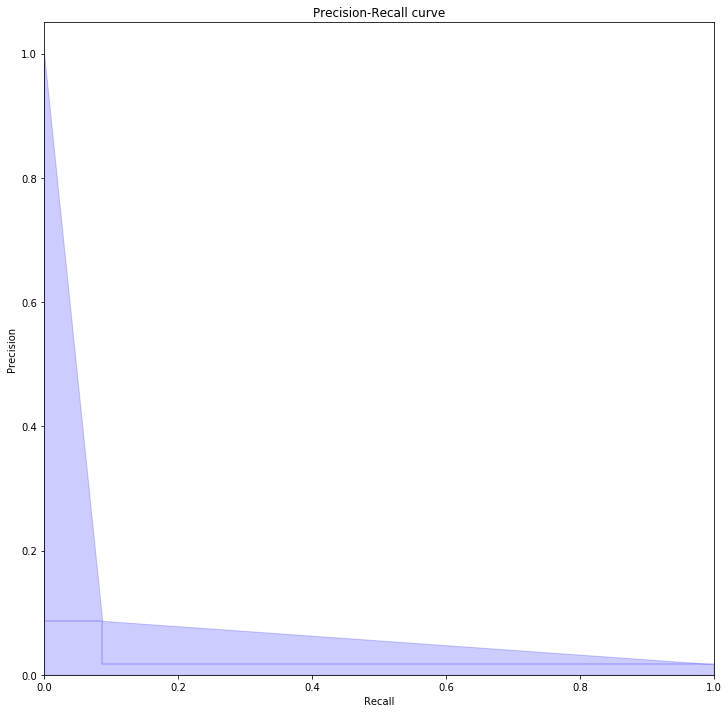

<module 'matplotlib.pyplot' from '/home/tony/source/relation-extraction/venv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [70]:
# Precision-Recall Curve
precision, recall, threshold = evaluation.compute_precision_recall_curve(
    y_true=df_test_y.values.reshape(-1, 1),
    y_pred=predicted_labels.reshape(-1, 1),
    classes=combined_labels
)

plt.rcParams["figure.figsize"] = (12, 12)
visualization.plot_precision_recall_curve(precision, recall)

In [52]:
evaluation.compute_score(predicted_labels, gold_labels, labels=combined_labels)

/home/tony/source/relation-extraction/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tony/source/relation-extraction/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/tony/source/relation-extraction/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tony/source/relation-extraction/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 

{'accuracy': 0.08686777309998492,
 'precision': 0.9499928950752299,
 'recall': 0.08686777309998492,
 'f1': 0.1482642075372364}

In [17]:
from sklearn.metrics import confusion_matrix

class_names = np.unique(combined_labels).ravel().tolist()

# Compute confusion matrix
cnf_matrix = confusion_matrix(
    y_true=gold_labels,
    y_pred=predicted_labels,
    labels=class_names
)
cnf_matrix

array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,   790,  2322, ...,  5722,  1283, 13688]])

Confusion matrix, without normalization
[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0   790  2322 ...  5722  1283 13688]]


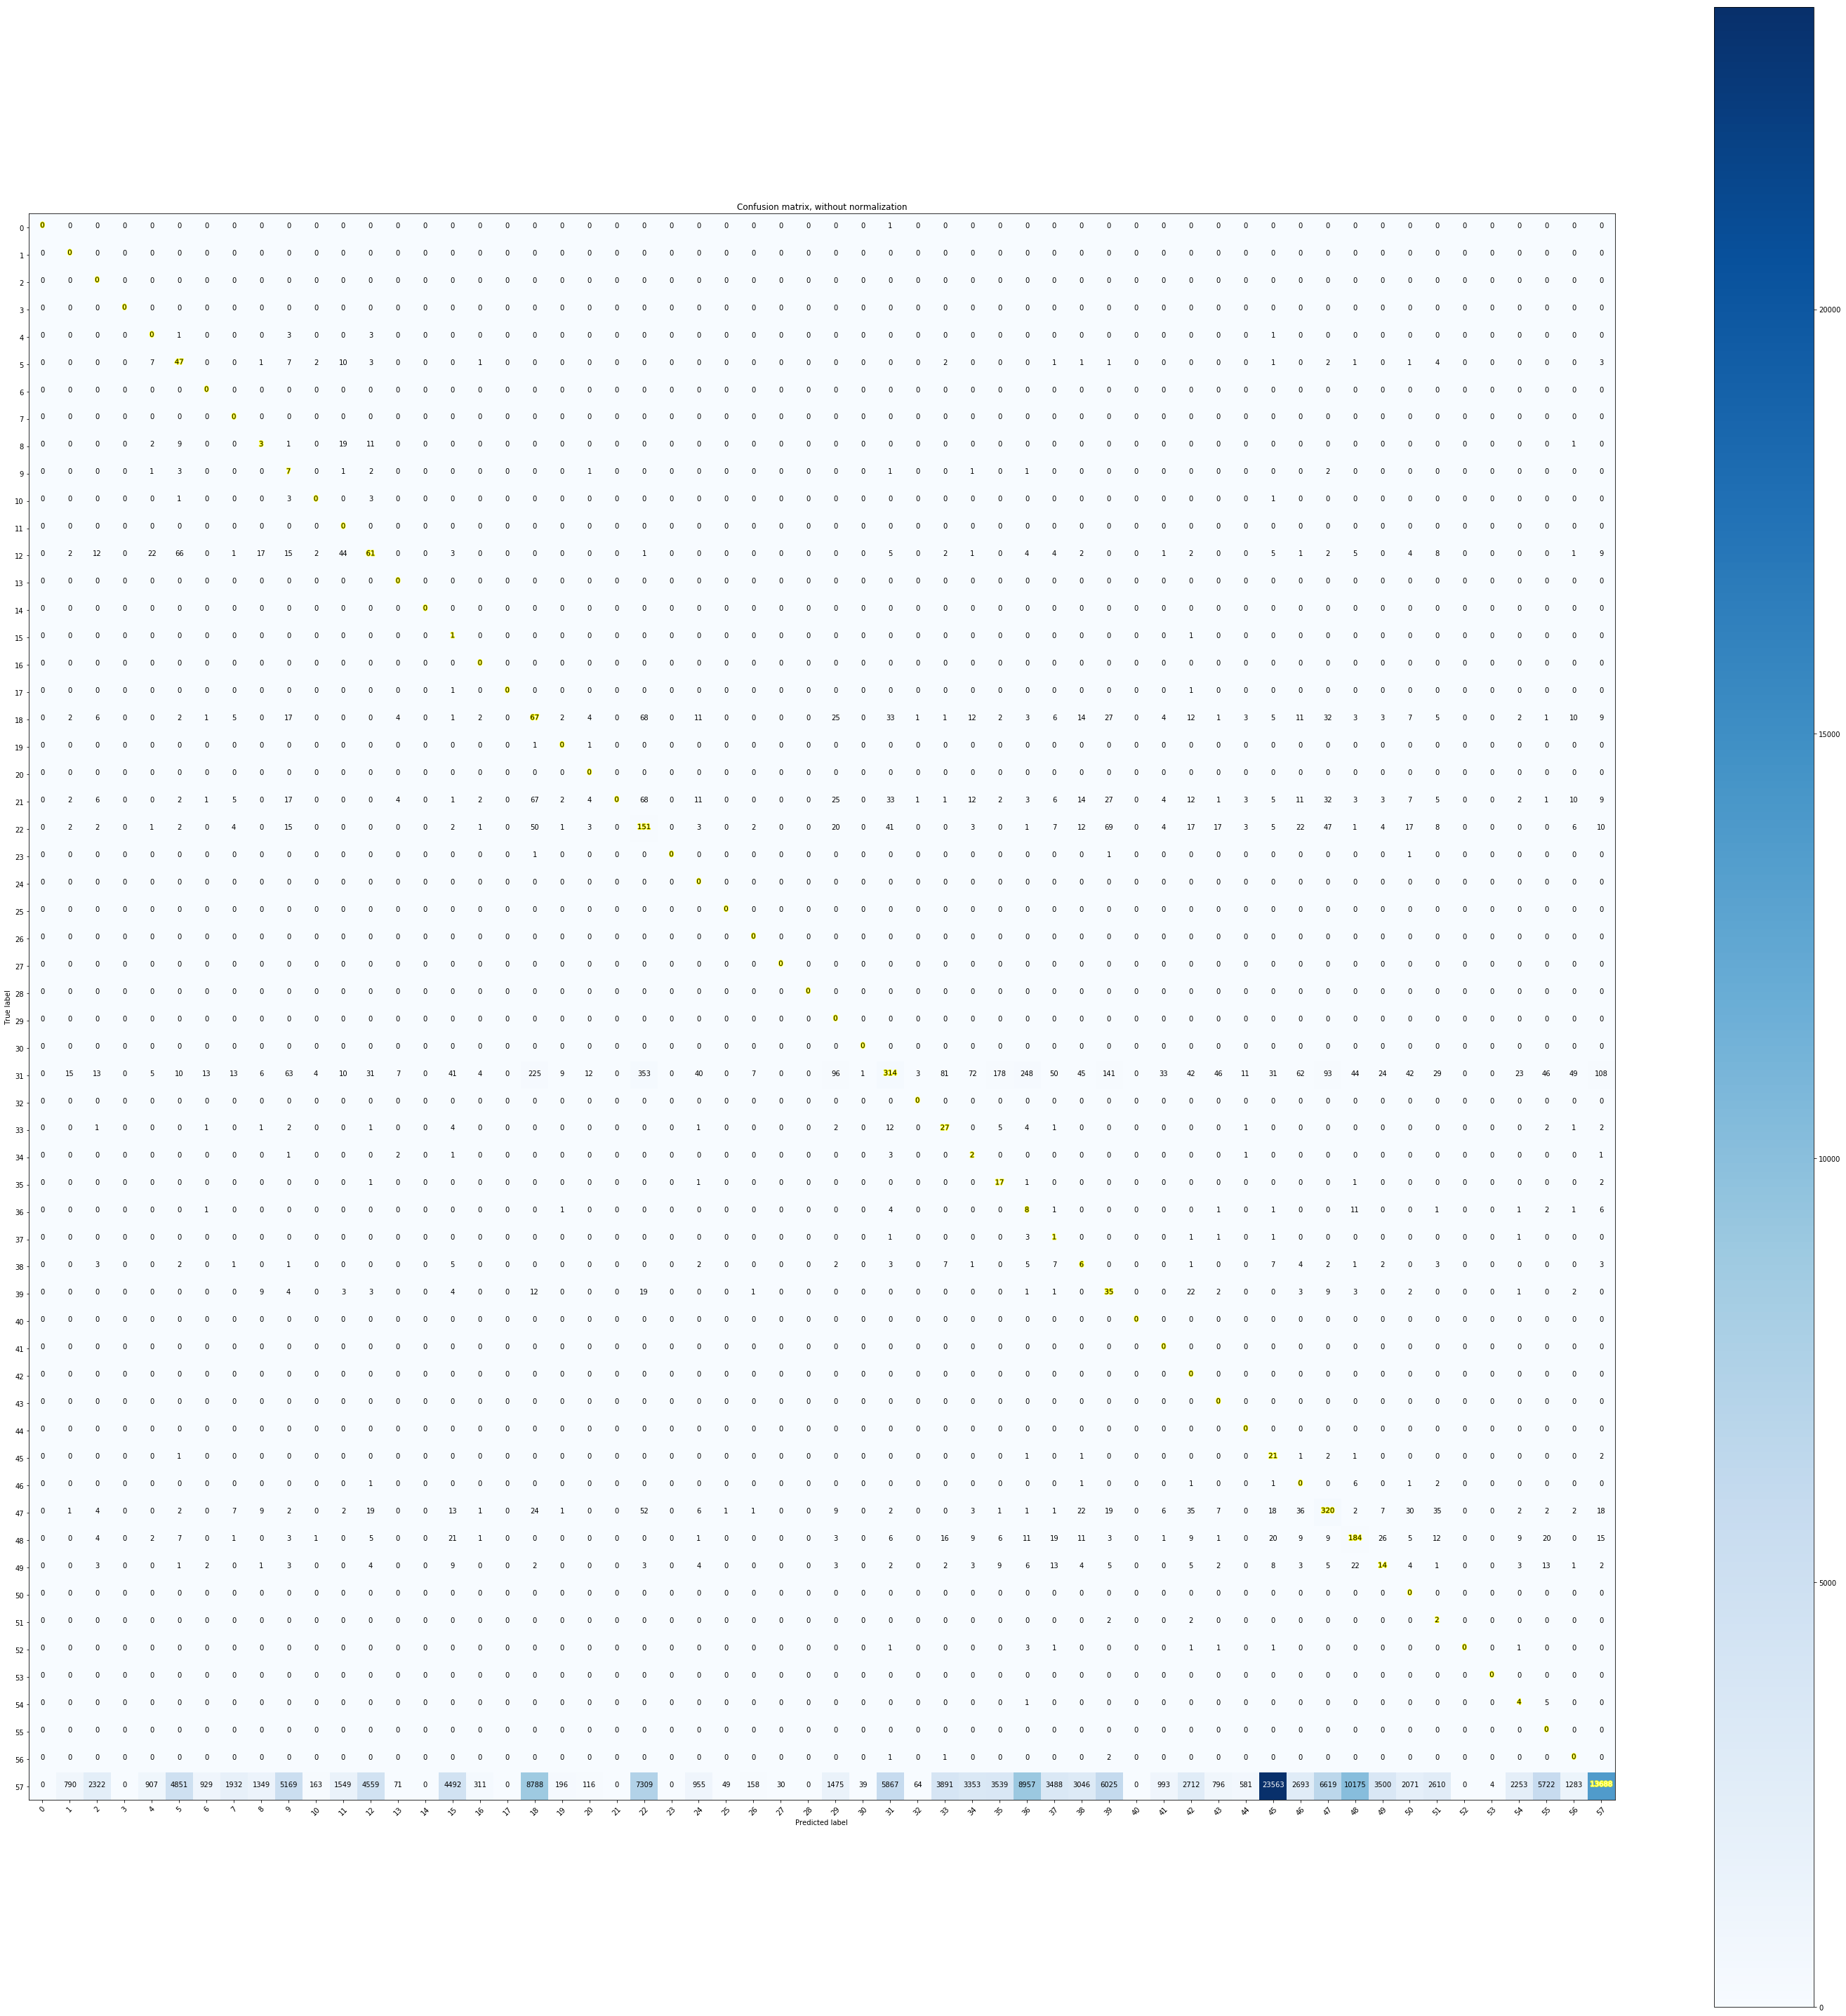

Normalized confusion matrix
[[0.  0.  0.  ... 0.  0.  0. ]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0.1]]


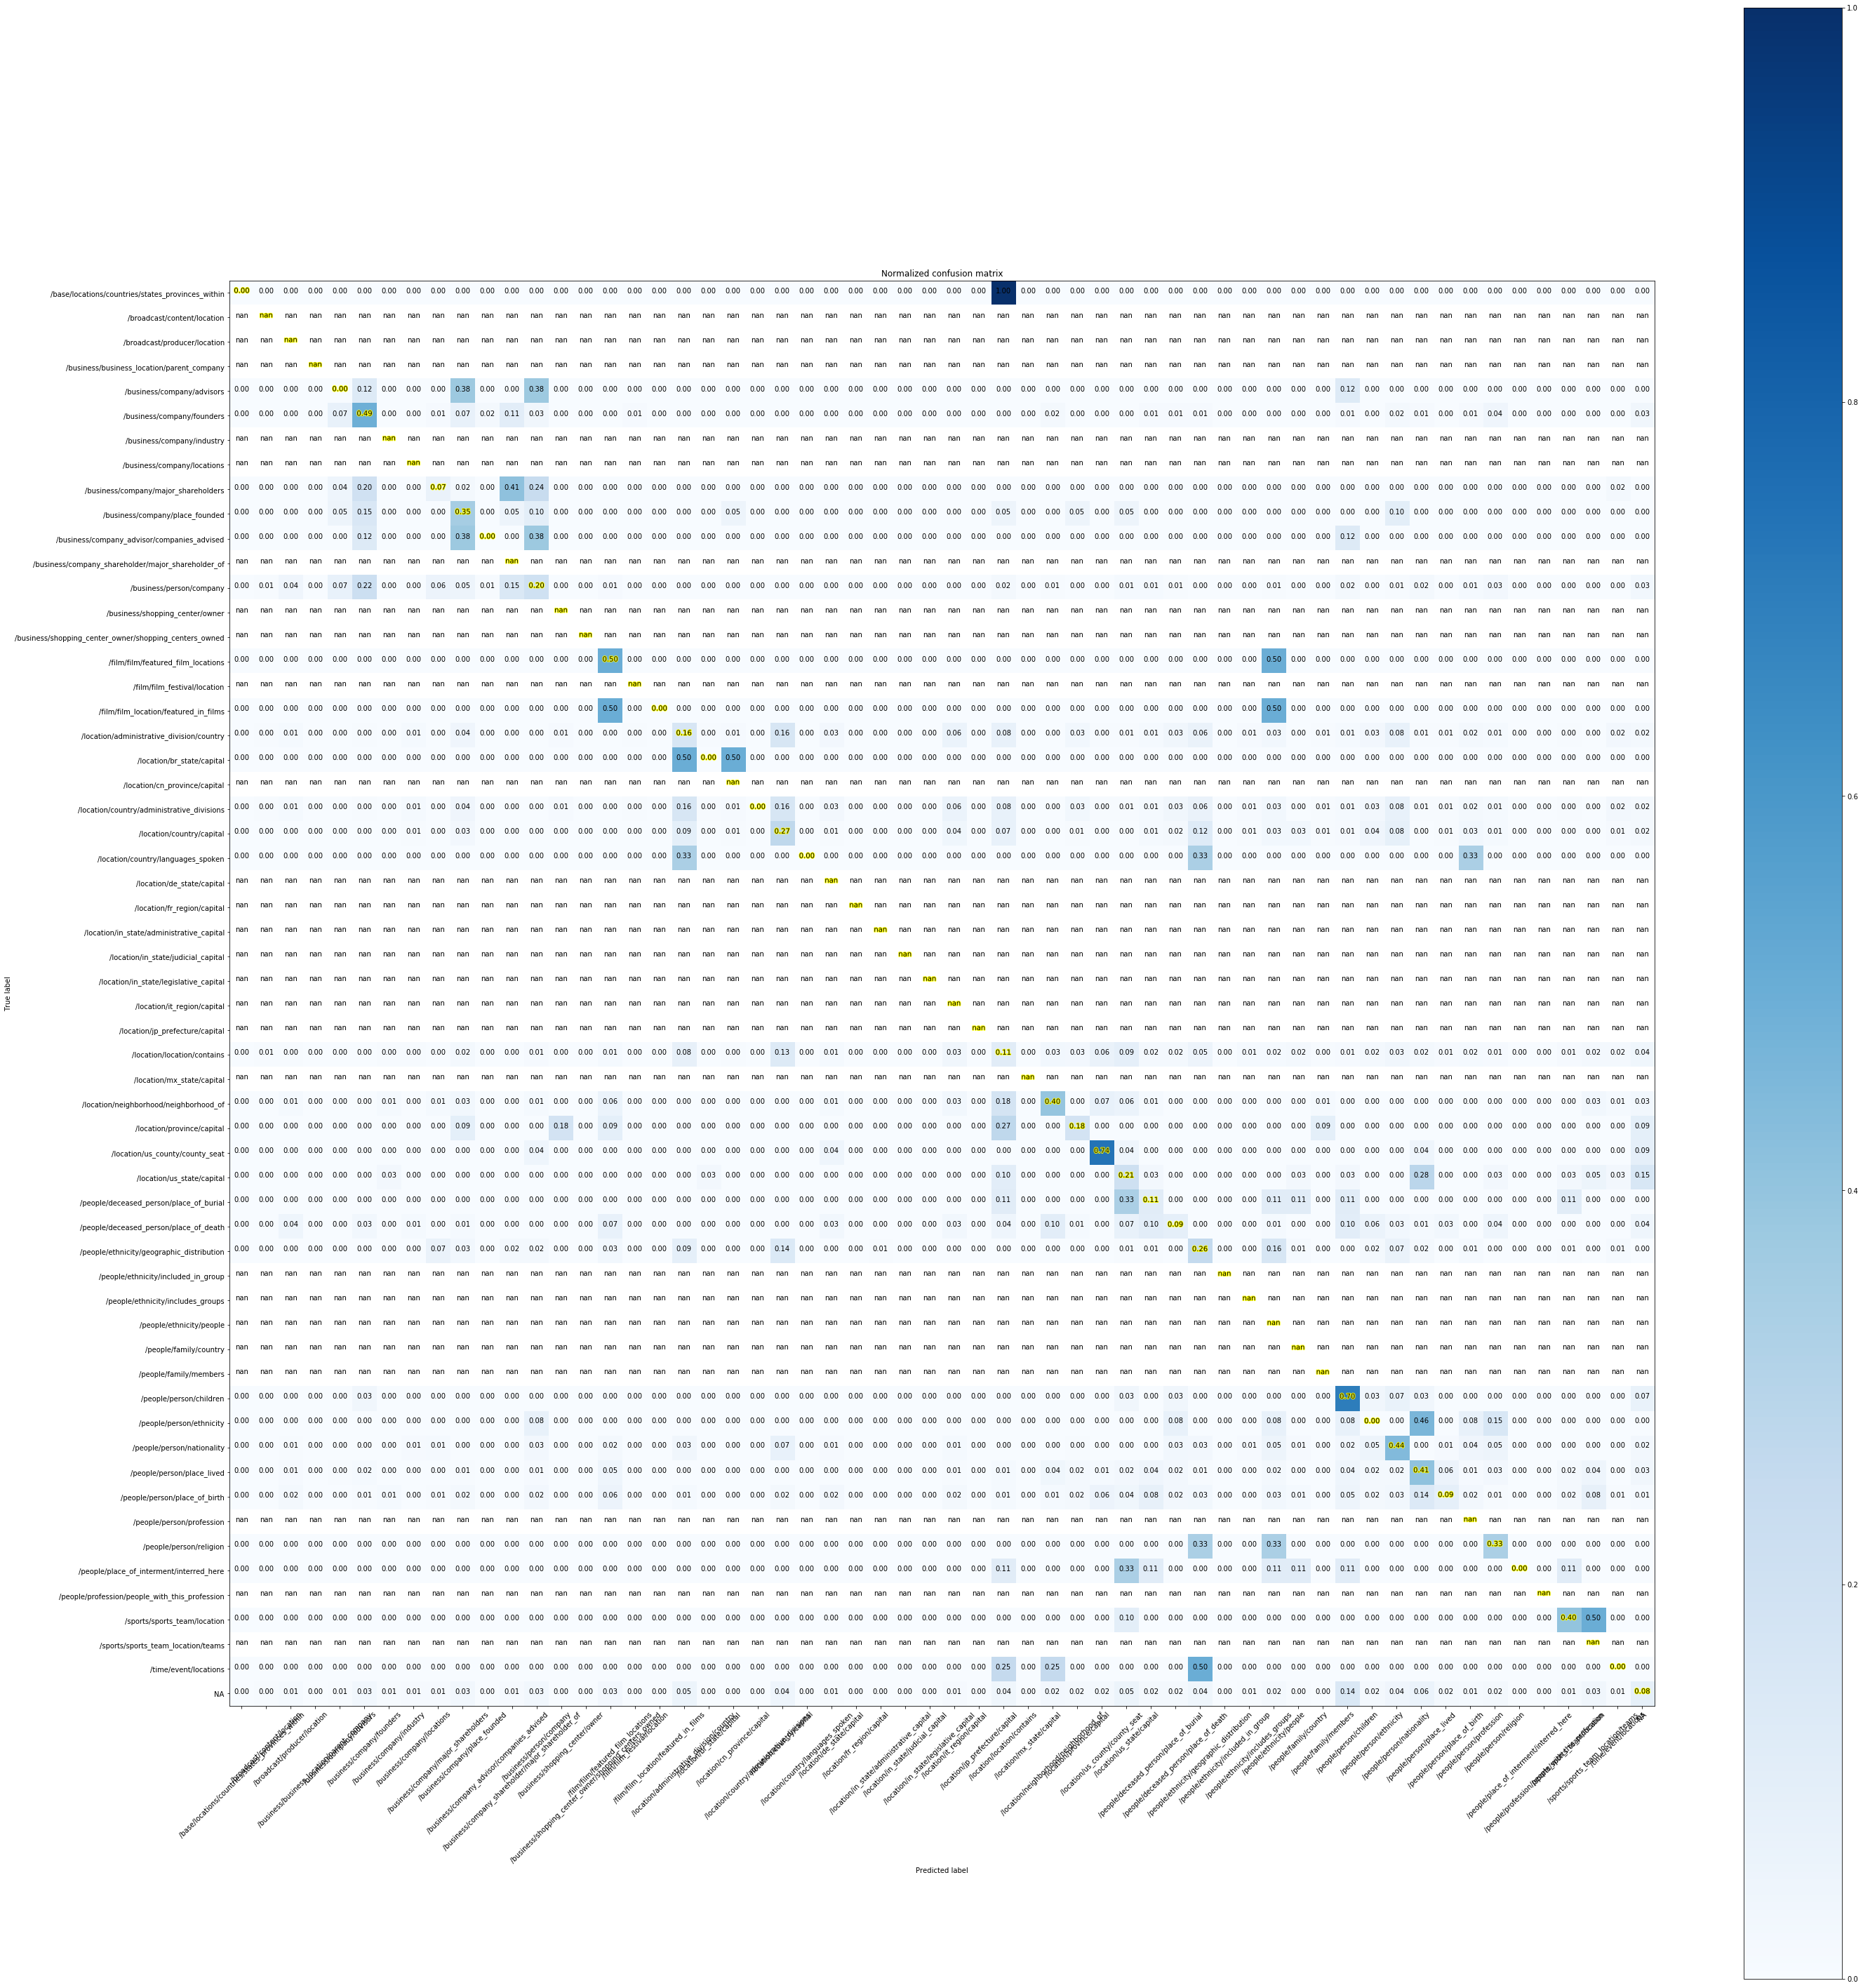

In [48]:
plt.rcParams["figure.figsize"] = (40, 40)

# Plot non-normalized confusion matrix
visualization.plot_confusion_matrix(cnf_matrix,
                      classes=range(len(class_names)), #class_names,
                      title='Confusion matrix, without normalization').show()

# Plot normalized confusion matrix
visualization.plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix').show()

In [45]:
# cnf_matrix
true_pos = np.diag(cnf_matrix)
false_pos = np.sum(cnf_matrix, axis=0) - true_pos
false_neg = np.sum(cnf_matrix, axis=1) - true_pos

precision = true_pos / (true_pos + false_pos)
# np.sum(precision)
np.nan_to_num(precision)
np.sum(np.nan_to_num(precision))
# np.sum(without_nan(precision))

/home/tony/source/relation-extraction/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


array([0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 9.4e-03, 0.0e+00,
       0.0e+00, 2.1e-03, 1.3e-03, 0.0e+00, 0.0e+00, 1.3e-02, 0.0e+00,
       0.0e+00, 2.2e-04, 0.0e+00, 0.0e+00, 7.3e-03, 0.0e+00, 0.0e+00,
       0.0e+00, 1.9e-02, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 5.0e-02, 0.0e+00, 6.7e-03, 5.8e-04,
       4.5e-03, 8.6e-04, 2.8e-04, 1.9e-03, 5.5e-03, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 8.9e-04, 0.0e+00, 4.5e-02, 1.8e-02,
       3.9e-03, 0.0e+00, 7.3e-04, 0.0e+00, 0.0e+00, 1.7e-03, 0.0e+00,
       0.0e+00, 9.9e-01])

1.1771471371759121

In [19]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(df_train_y), df_train_y)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1166.3325892857142,
 1: 131.4177565392354,
 2: 491.0874060150376,
 3: 1036.7400793650793,
 4: 10.35589424449025,
 5: 1866.1321428571428,
 6: 491.0874060150376,
 7: 28.44713632404181,
 8: 14.399167768959435,
 9: 4665.330357142857,
 10: 47.12454906204906,
 11: 1.2719003154696993,
 12: 9330.660714285714,
 13: 9330.660714285714,
 14: 518.3700396825396,
 15: 2332.6651785714284,
 16: 518.3700396825396,
 17: 1.2806287008352613,
 18: 2332.6651785714284,
 19: 4665.330357142857,
 20: 1.2806287008352613,
 21: 1.0503952171885302,
 22: 1332.9515306122448,
 23: 9330.660714285714,
 24: 2332.6651785714284,
 25: 3110.220238095238,
 26: 2332.6651785714284,
 27: 424.1209415584416,
 28: 4665.330357142857,
 29: 0.1398459362762206,
 30: 9330.660714285714,
 31: 1.0060011551790529,
 32: 239.24771062271063,
 33: 84.82418831168832,
 34: 11.692557286072324,
 35: 388.77752976190476,
 36: 3.8524610711336558,
 37: 108.49605481727575,
 38: 1332.9515306122448,
 39: 1332.9515306122448,
 40: 73.46976940382453,
 41: